## Bitcoin Price Prediction

In this particular project, we will make a time series model for bitcoin prices. Data include from April 2012 to 25th May 2022. 

<img src="btc_current.png" height=400 width=600>

In this particular project we will run a series of deep learning model experiments
* Dense Neural Network
* LSTM Neural Network
* GRU Neural Network
* 1 Dimensional CNN Neural Network
* Multivariate model with price and volume
* Multivariate model with price and block-reward size
* Multivariate model by combining price, volume and reward size.

To start with, we need a dataset to work on. Our dataset contains data of apporx 10 years. <br/>
Let's load the dataframe using pandas: 

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_btc = pd.read_csv(r"btc_data.csv",parse_dates=["Date"],index_col=["Date"])
df_btc.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2012-04-25,5.1,5.1,5.2,5,35.64K,0.00%
2012-04-26,5.1,5.1,5.2,5,57.36K,0.00%
2012-04-27,5.1,5.1,5.1,5,25.87K,0.00%
2012-04-28,5,5.1,5.1,4.8,91.59K,-2.54%
2012-04-29,4.9,5,5,4.9,22.23K,-1.61%


We have made index column as the date for easy intepretation. 

Also, let's view the last of the data.

In [3]:
df_btc.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2022-05-21,"29,434.60","29,188.70","29,623.20","28,953.90",32.27K,0.88%
2022-05-22,"30,286.60","29,433.00","30,462.00","29,260.10",50.60K,2.89%
2022-05-23,"29,093.30","30,287.30","30,644.80","28,913.60",92.10K,-3.94%
2022-05-24,"29,648.70","29,091.60","29,810.80","28,706.10",79.42K,1.91%
2022-05-25,"29,887.90","29,648.70","30,202.30","29,551.00",87.48K,0.81%


Since, we have price data with us, we don't need all of the columns like "Open","High","Low" etc to make the model. However, we will make a model considering volume along with Price, to see how does it performs in multivariate scenario. For the time being we will continue with univariate model. So, let's satrt with "Price" and drop all other columns. 

In [4]:
df_price  = df_btc[["Price"]]
df_price.head()

,Price
Date,
2012-04-25,5.1
2012-04-26,5.1
2012-04-27,5.1
2012-04-28,5
2012-04-29,4.9


In [5]:
# Check the total shape.
df_price.shape

(3683, 1)

So, we have total of 3683 rows.

Next we will plot a graph for the data. But since the number might contains comma, datatype will be considered as <b>object</b> by the pandas dataframe. So, to confirm this let's check the datatype. 

In [6]:
df_price.dtypes

Price    object
dtype: object

As expected, it is object. So, let's see how many commas are present in Price column. 

In [7]:
df_price[df_price["Price"].str.contains(",")]

,Price
Date,
2013-11-27,"1,079.90"
2013-11-28,"1,101.40"
2013-11-29,"1,206.90"
2013-11-30,"1,205.70"
2013-12-01,"1,004.40"
...,...
2022-05-21,"29,434.60"
2022-05-22,"30,286.60"
2022-05-23,"29,093.30"


So, total of 1498 columns contains commas. We need to remove these commas to convert these values into float values.

In [8]:
df_price["Price"] = df_price["Price"].apply(lambda x:x.replace(',',''))

In [9]:
df_price[df_price["Price"].str.contains(",")]

,Price
Date,


Now there is no comma remaining. Let's convert the data into float

In [10]:
df_price["Price"] = df_price["Price"].astype(np.float32)

Let's see how does it looks in terms of graph.

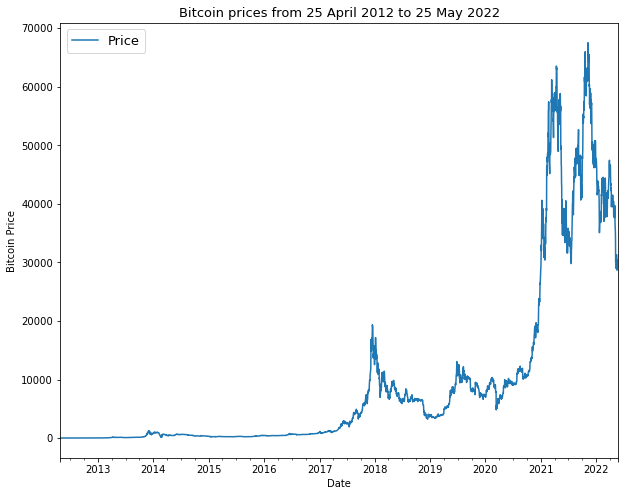

In [73]:
import matplotlib.pyplot as plt
df_price.plot(figsize=(10,8))
plt.ylabel("Bitcoin Price")
plt.title("Bitcoin prices from 25 April 2012 to 25 May 2022",fontsize=13)
plt.legend(fontsize=13)
plt.show();

Now since this is a time series problem, we cannot use `train_test_split` function of sklearn to divide teh data into train and test set. As, using it, would break the chain and choose the data randomly from somewhere in the dataframe. <br/>
Let's make the data into two different array for futher processing.

In [74]:
sequence_length = df_price.index.to_numpy()
prices = df_price["Price"].to_numpy()

In [75]:
sequence_length[:10]

array(['2012-04-25T00:00:00.000000000', '2012-04-26T00:00:00.000000000',
       '2012-04-27T00:00:00.000000000', '2012-04-28T00:00:00.000000000',
       '2012-04-29T00:00:00.000000000', '2012-04-30T00:00:00.000000000',
       '2012-05-01T00:00:00.000000000', '2012-05-02T00:00:00.000000000',
       '2012-05-03T00:00:00.000000000', '2012-05-04T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [76]:
prices[:10]

array([5.1, 5.1, 5.1, 5. , 4.9, 4.9, 5. , 5.1, 5.1, 5.1], dtype=float32)

Since, `train_test_split` of sklearn, doesn't work in TS data, let's manually divide it into 80% training and 20% testing data. 

In [78]:
# Create train test length for time series by choosing the split size.
split_size = int(0.8 * len(prices))
X_train, y_train = sequence_length[:split_size], prices[:split_size]
X_test, y_test = sequence_length[split_size:], prices[split_size:]

# Check their length 
len(X_train), len(X_test), len(y_train), len(y_test)

(2946, 737, 2946, 737)

So, we are done withg splitting of the data, let's plot a graph, demonstrating both of these train and test data.  

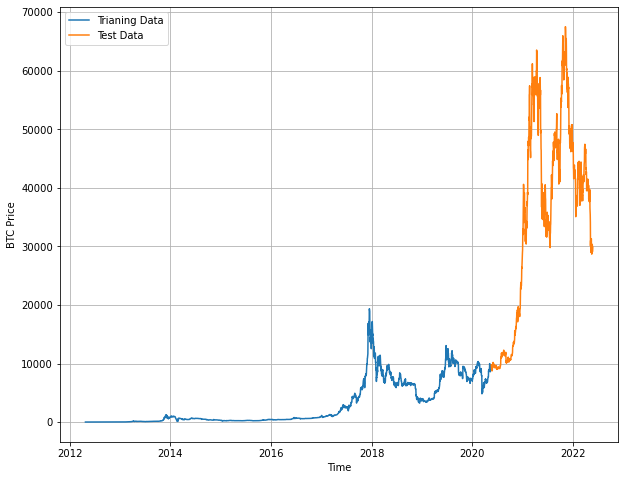

In [80]:
plt.figure(figsize=(10,8))
plt.plot(X_train,y_train,label="Trianing Data")
plt.plot(X_test,y_test,label="Test Data")
plt.xlabel("Time")
plt.ylabel("BTC Price")
plt.legend()
plt.grid(True)
plt.show();

To make the model of timeseries in neural network we have too make the data into windows frame format. Suppose we want to have 7 dyas of input and 1 day of output. We will demonstrate this on the sample data using `tf.keras.preprocessing.sequence.TimeseriesGenerator`. It generates batches of temporal data. Let's see a demo of it having 7 uints of input length and 1 unit of output length.

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
sequence_data = np.arange(1,11)
output_data = np.arange(1,11)
generator_data = TimeseriesGenerator(sequence_data,output_data,length=7,sampling_rate=1,batch_size=1)

In [15]:
# Let's check the length of the dataset.
print(f"Length of dataset generator: {len(generator_data)}")

Length of dataset generator: 3


In [16]:
for i in range(len(generator_data)):
    x,y = generator_data[i]
    print(f"Input: {x} ---> Target: {y}")

Input: [[1 2 3 4 5 6 7]] ---> Target: [8]
Input: [[2 3 4 5 6 7 8]] ---> Target: [9]
Input: [[3 4 5 6 7 8 9]] ---> Target: [10]


So, as demonstrated above we have to make the data into this format. Aim is to move the window sequence by output_data length and have an input window of desired days. This would be better with image below. We will consider above example for this. 

<img src="window.png" height="500" width="600">

Now to implement this on the dataframe, we will use a tensorflow function <a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array"> `tf.keras.utils.timeseries_dataset_from_array`. </a>

In [11]:
import tensorflow as tf

In [104]:
data_seq = tf.keras.utils.timeseries_dataset_from_array(data=prices,
                                                        targets=prices,
                                                        sequence_length=7,
                                                        sequence_stride=1)

Here we have chosen `sequence_length=7` and `sequence_stride=1`, becuase we want to have input of 7 days and wants to move the sliding window by 1 day.

In [105]:
len(data_seq)

29

In [106]:
train_size, test_size = int(0.8*len(data_seq)), int(0.2*(len(data_seq))) 

In [107]:
train_size, test_size

(23, 5)

In [108]:
train_data_seq = data_seq.take(train_size)
test_data_seq = data_seq.skip(train_size).take(test_size)

In [109]:
for x,y in train_data_seq.take(1):
    print(f"{x[:1].numpy()} ----> {y[:1].numpy()}")

[[5.1 5.1 5.1 5.  4.9 4.9 5. ]] ----> [5.1]


In [114]:
df_price.head(8)

,Price
Date,
2012-04-25,5.1
2012-04-26,5.1
2012-04-27,5.1
2012-04-28,5.0
2012-04-29,4.9
2012-04-30,4.9
2012-05-01,5.0
2012-05-02,5.1


### <b> Model_1: Simple Dense Model </b>

Now the next task is to build the model. For the time being we will start with simple ANN dense model. For purpose of building model we will take 7 units in input layer, as we are predicting price weekly. Hidden layers will contain activation function "relu", as "relu" works best in hidden layers. And in the output layer there won't be any activation function and will only 1 unit as for price of 7 days, output would be 1.  

In [121]:
# Set the random seed for reproducibility
tf.random.set_seed(42)

# Building a functional dense model
inputs = tf.keras.layers.Input(shape=(7,),dtype=tf.float32) # 7 days of data will come as input
x = tf.keras.layers.Dense(128,activation="relu")(inputs)
x = tf.keras.layers.Dense(64,activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)

# Create the model
model_1 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_1.compile(loss="mae", # let's choose a simple loss function 
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["mae"])

In [122]:
# Plot the summary of the model
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,345
Trainable params: 9,345
Non-trainable params: 0
_________________________________________________________________


Now let's fit the data.

In [123]:
# Fit the model 
model_1.fit(train_data_seq,
           epochs=100,
           verbose=0,
           validation_data=test_data_seq,
           callbacks=[tf.keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)])

Let's make a function to see the performance of the model.

In [125]:
loss_model_1 = model_1.evaluate(test_data_seq)
loss_model_1

5/5 [==============================] - 1s 4ms/step - loss: 170.0273 - mae: 170.0273


[170.0272979736328, 170.0272979736328]

Let's make some prediction

In [681]:
model_1.predict(test_data_seq)[:5]

array([[9708.833],
       [9778.047],
       [9758.945],
       [9469.24 ],
       [9061.786]], dtype=float32)

### <b> Model_2: LSTM (default configuration) </b>
LSTM stands for Long Short Term Memory. LSTM is particulraly useful in maintaing information in memory period for longer duration of time. It is a varaint of RNN. <br/>
We cannot directly apply LSTM, since LSTM expects data into format of <b> [batch,timesteps,feature] </b>. We have already divided our data into batch_size, so batch is we have, timesteps is that we have taken care by making window of 7 inputs. So for remaining we will use lambda layer `tf.keras.layers.Lambda`. Lambda layers wraps arbitrary expressions as a Layer object.  <br/>
So, let's implement this.

In [131]:
# Set the random seed for reproducibility 
tf.random.set_seed(42)

# Build the LSTM model
inputs = tf.keras.layers.Input(shape=(7,),dtype=tf.float32)
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(inputs) # using Lambda layer for the LSTM
x = tf.keras.layers.LSTM(128)(x)
x = tf.keras.layers.Dense(64,activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)

# Create the model
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="mae",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["mae"])

In [132]:
# plot the summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
lambda (Lambda)              (None, 1, 7)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               69632     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 77,953
Trainable params: 77,953
Non-trainable params: 0
_________________________________________________________________


Now let's fit the model using EarlyCallback.

In [133]:
model_2.fit(train_data_seq,
           epochs=100,
           verbose=0,
           validation_data=test_data_seq,
           callbacks=[tf.keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)])

Let's check how well our model has performed. 

In [135]:
loss_model_2 = model_2.evaluate(test_data_seq)
loss_model_2

5/5 [==============================] - 1s 16ms/step - loss: 34310.7422 - mae: 34310.7422


[34310.7421875, 34310.7421875]

If we compare from our model_1 loss was approx 170, but here we have got 34310; this is huge increase in loss. We can reduce this loss by using activation function as "relu" instead of by deafult activation of "tanh". Let's build the model again with activation function as "relu".

In [682]:
# Let's make some prediction.
model_2.predict(test_data_seq)[:5]

array([[853.67505],
       [815.28314],
       [829.9136 ],
       [796.3733 ],
       [793.3801 ]], dtype=float32)

These predictions are far off from that predicted by model_1.

### <b> Model_3: LSTM (modified parameters) </b>

In [137]:
# Set the random seed for reproducibility 
tf.random.set_seed(42)

# Build the LSTM model
inputs = tf.keras.layers.Input(shape=(7,),dtype=tf.float32)
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(inputs) # using Lambda layer for the LSTM
x = tf.keras.layers.LSTM(128,activation="relu")(x)
x = tf.keras.layers.Dense(64,activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)

# Create the model
model_3 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_3.compile(loss="mae",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["mae"])

<b> Note: </b> We are getting above warning because there are certain requirements for cuDNN implementaion. If any of the requirements doesn't meet it shows the warning, as we get. Since we have changed the activation from "tanh" to "relu", we are getting above warning: <br/> <i> "WARNING:tensorflow:Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU." </i>

The requirements to use the cuDNN implementation are: <br/>
<i>
activation == tanh <br/>
recurrent_activation == sigmoid <br/>
recurrent_dropout == 0 <br/>
unroll is False <br/>
use_bias is True <br/>
Inputs, if use masking, are strictly right-padded. <br/>
Eager execution is enabled in the outermost context. <br/> </i>

If anyone of these above mentioned criteria doesn't met, we are likely to get the warning.

Noew let's fit the model.

In [138]:
model_3.fit(train_data_seq,
           epochs=100,
           verbose=0,
           validation_data=test_data_seq,
           callbacks=[tf.keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)])

In [139]:
loss_model_3 = model_3.evaluate(test_data_seq)
loss_model_3

5/5 [==============================] - 1s 7ms/step - loss: 863.2108 - mae: 863.2108


[863.2107543945312, 863.2107543945312]

So, our model has performed much better as comapre to earlier model_2.

In [683]:
# Let's make some prediction.
model_3.predict(test_data_seq)[:5]

array([[9534.82 ],
       [9349.553],
       [9294.838],
       [9178.065],
       [9098.823]], dtype=float32)

This prediction is somewhere in line with model_1 predictions.

### <b> Model_4: GRU </b> 

Now let's perform GRU with above data. GRU stands for Gated Rectified Unit. It is also a variant of RNN.This time we will start with "relu" instaed of by default "tanh" as it also suffers from same problem as LSTM.  

In [140]:
# Set the random seed for reproducibility 
tf.random.set_seed(42)

# Build the LSTM model
inputs = tf.keras.layers.Input(shape=(7,),dtype=tf.float32)
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(inputs) # using Lambda layer for the LSTM
x = tf.keras.layers.GRU(128,activation="relu")(x)
x = tf.keras.layers.Dense(64,activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)

# Create the model
model_4 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_4.compile(loss="mae",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["mae"])

We are getting the same warning as we have discussed above.

Now let's fit the model.

In [141]:
model_4.fit(train_data_seq,
           epochs=100,
           verbose=0,
           validation_data=test_data_seq,
           callbacks=[tf.keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)])

In [142]:
loss_model_4 = model_4.evaluate(test_data_seq)
loss_model_4

5/5 [==============================] - 1s 8ms/step - loss: 1035.5074 - mae: 1035.5074


[1035.5074462890625, 1035.5074462890625]

So, our LSTM model has performed better than GRU.

In [684]:
# Let's make some prediction.
model_4.predict(test_data_seq)[:5]

array([[9572.171],
       [9440.171],
       [9636.391],
       [9452.727],
       [9322.488]], dtype=float32)

### <b> Model_5: Convolution 1D </b>
Convolution neural network not only gives good result with images but also with text data and numerical sequences. CNN 1D takes input in the format of `batch_shape + (steps, input_dim)` . To adjust input_dim, we will use lambda layer. <br/> So, let's try CNN 1D. Before implementing, one thing to be noted that here padding would be <i> *"causal"* </i> not *"valid"* or "same". Because this is temporal data.

In [154]:
# Set the seed for random producibility 
tf.random.set_seed(42)

# Make the model
# Create model
model_5 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(7,),dtype=tf.float32),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # adjustment to make iit comatible with CNN 1D
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"), # use "causal" with temporal data
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(1)
])

# Compile the model
model_5.compile(loss="mae",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["mae"])

In [155]:
model_5.fit(train_data_seq,
           epochs=100,
           verbose=0,
           validation_data=test_data_seq,
           callbacks=[tf.keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)])

In [156]:
model_5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_9 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 128)            4608      
_________________________________________________________________
dense_19 (Dense)             (None, 1, 128)            16512     
_________________________________________________________________
dense_20 (Dense)             (None, 1, 1)              129       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________


In [157]:
loss_model_5 = model_5.evaluate(test_data_seq)
loss_model_5

5/5 [==============================] - 1s 4ms/step - loss: 316.3491 - mae: 316.3491


[316.3490905761719, 316.3490905761719]

Our convolution model has performed better than LSTM and GRU. 

In [685]:
# Let's make some prediction.
model_5.predict(test_data_seq)[:5]

array([[[9687.807]],

       [[9744.072]],

       [[9684.765]],

       [[9360.187]],

       [[9085.032]]], dtype=float32)

### <b> Model_6: Simple Denese 30 days period </b>

We have constructed the model for performing weekly data.And as of now our simple Dense model has perfomed best, so using simple dense model we will predict the outcome considering 30 days of data  for one single day.   

For this purpose we will have to make the windows of 30 by applying the function `tf.keras.utils.timeseries_dataset_from_array`. Here in this function, we will set the value of `sequence_length=30`.

In [159]:
data_seq_monthly = tf.keras.utils.timeseries_dataset_from_array(data=prices,
                                                        targets=prices,
                                                        sequence_length=30,
                                                        sequence_stride=1)

In [160]:
len(data_seq_monthly)

29

In [161]:
train_size, test_size = int(0.8*len(data_seq_monthly)), int(0.2*(len(data_seq_monthly))) 

In [162]:
train_data_seq_mon = data_seq_monthly.take(train_size)
test_data_seq_mon = data_seq_monthly.skip(train_size).take(test_size)
for x,y in train_data_seq_mon.take(1):
    print(f"{x[:1].numpy()} ----> {y[:1].numpy()}")

In [166]:
for x,y in train_data_seq_mon.take(1):
    print(f"{x[:1].numpy()} ----> {y[:1].numpy()}")

[[5.1 5.1 5.1 5.  4.9 4.9 5.  5.1 5.1 5.1 5.1 5.1 5.1 5.1 5.  4.8 5.  4.9
  4.9 5.  5.  5.1 5.1 5.1 5.1 5.1 5.1 5.1 5.1 5.1]] ----> [5.1]


Hence we have constructed our windows of 30 days.

In [167]:
# Set the random seed for reproducibility
tf.random.set_seed(42)

# Building a functional dense model
inputs = tf.keras.layers.Input(shape=(30,),dtype=tf.float32) # 30 days of data will come as input
x = tf.keras.layers.Dense(128,activation="relu")(inputs)
x = tf.keras.layers.Dense(64,activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)

# Create the model
model_6 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_6.compile(loss="mae", # let's choose a simple loss function 
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["mae"])

In [169]:
# Plot the summary of the model 
model_6.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________


In [168]:
# Fit the model 
model_6.fit(train_data_seq_mon,
           epochs=100,
           verbose=0,
           validation_data=test_data_seq_mon,
           callbacks=[tf.keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)])

In [170]:
loss_model_6 = model_6.evaluate(test_data_seq_mon)
loss_model_6

5/5 [==============================] - 1s 4ms/step - loss: 1001.1749 - mae: 1001.1749


[1001.1749267578125, 1001.1749267578125]

In [687]:
# Let's make some prediction.
model_6.predict(test_data_seq_mon)[:5]

array([[9452.819],
       [9330.489],
       [9307.7  ],
       [9151.229],
       [8857.998]], dtype=float32)

### <b> Model_7: Multivariate Time Series (price & volume) </b>

Till now we have dealt with univariate time series data, now we will make it multi-variate by considering volume also, and let's see wheteher there any increase in accuracy. We will again use simple dense model with 7 days of input and 1 day of output. 

In [479]:
df_btc.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2012-04-25,5.1,5.1,5.2,5,35.64K,0.00%
2012-04-26,5.1,5.1,5.2,5,57.36K,0.00%
2012-04-27,5.1,5.1,5.1,5,25.87K,0.00%
2012-04-28,5,5.1,5.1,4.8,91.59K,-2.54%
2012-04-29,4.9,5,5,4.9,22.23K,-1.61%


In [480]:
df_vol = df_btc[["Price","Vol."]]

In [481]:
df_vol.head()

,Price,Vol.
Date,,
2012-04-25,5.1,35.64K
2012-04-26,5.1,57.36K
2012-04-27,5.1,25.87K
2012-04-28,5,91.59K
2012-04-29,4.9,22.23K


In [482]:
import warnings 
warnings.filterwarnings("ignore")

In [483]:
df_vol.dtypes

Price    object
Vol.     object
dtype: object

We need to change the Vol. into numerical form.

In [484]:
df_vol.head()

,Price,Vol.
Date,,
2012-04-25,5.1,35.64K
2012-04-26,5.1,57.36K
2012-04-27,5.1,25.87K
2012-04-28,5,91.59K
2012-04-29,4.9,22.23K


In [485]:
num_chars = (re.findall("[a-zA-Z]",text) for text in df_vol["Vol."])
text = [element for sub in num_chars for element in sub]
set(text)

{'B', 'K', 'M'}

So, we have seen that there are three unique words, where "B" represents Billion, "K" represents thousands and "M" represents million. So, for billion we need to multiply by 10<sup>9</sup>, for million we need to multiply by 10<sup>6</sup> and for thousand we need to multiply them by 10<sup>3</sup>. Before multiplying let's visualize each one of "K", "M" and "B".   

In [486]:
df_vol[df_vol["Vol."].str.contains("K")][:5]

,Price,Vol.
Date,,
2012-04-25,5.1,35.64K
2012-04-26,5.1,57.36K
2012-04-27,5.1,25.87K
2012-04-28,5,91.59K
2012-04-29,4.9,22.23K


In [487]:
df_vol[df_vol["Vol."].str.contains("M")][:5]

,Price,Vol.
Date,,
2018-08-14,"6,190.20",3.66M
2018-08-15,"6,256.90",3.74M
2018-08-16,"6,306.70",3.50M
2018-08-17,"6,581.70",3.20M
2018-08-18,"6,379.10",3.15M


In [488]:
df_vol[df_vol["Vol."].str.contains("B")][:5]

,Price,Vol.
Date,,
2022-03-04,"39,142.70",3.21B
2022-03-05,"39,395.80",1.50B
2022-03-06,"38,403.10",1.93B
2022-03-07,"38,024.80",3.02B
2022-03-08,"38,744.80",2.67B


Now let's execute the multiplying opeartion that we have discussed above. In python 1e denotes 10.  

In [489]:
df_vol["Vol."] = df_vol['Vol.'].replace({'K': '*1e3', 'M': '*1e6','B':'*1e9'}, regex=True).map(pd.eval).astype(np.float32)

In [490]:
df_vol.head()

,Price,Vol.
Date,,
2012-04-25,5.1,35640.0
2012-04-26,5.1,57360.0
2012-04-27,5.1,25870.0
2012-04-28,5,91590.0
2012-04-29,4.9,22230.0


In [491]:
df_vol["Vol."].max()

4470000128.0

So, above method has worked.

In [492]:
# Convert the data 
df_vol["Price"] = df_vol["Price"].replace(",","")

In [493]:
df_vol.head()

,Price,Vol.
Date,,
2012-04-25,5.1,35640.0
2012-04-26,5.1,57360.0
2012-04-27,5.1,25870.0
2012-04-28,5,91590.0
2012-04-29,4.9,22230.0


In [494]:
df_vol["Price"] = df_vol["Price"].apply(lambda x:x.replace(',',''))

In [495]:
df_vol["Price"] = df_vol["Price"].astype(np.float32)

In [496]:
df_vol.dtypes

Price    float32
Vol.     float32
dtype: object

Now every things looks good, we can construct our multvariate model.

To construct a multivariate model, we need to convert make a windowed format. For this purpose we will use `pandas.DataFrame.shift` function of pandas, as our data is in dataframe. This function provides `shift` option, that let us make a window by specified number of periods. 

Since, we are constructing windows for 7 days for output of one day.

In [497]:
sequence_length = 7
output_length = 1

Let's make a copy of df_vol dataframe for further purpose and work on copied one. 

In [498]:
btc_window = df_vol.copy() 

In [499]:
for i in range(sequence_length): # total 7 shift length
    btc_window[f"Price+{i+1}"] = btc_window["Price"].shift(periods=i+1)
btc_window.head(8)

,Price,Vol.,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2012-04-25,5.1,35640.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-26,5.1,57360.0,5.1,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-27,5.1,25870.0,5.1,5.1,NaN,NaN,NaN,NaN,NaN
2012-04-28,5.0,91590.0,5.1,5.1,5.1,NaN,NaN,NaN,NaN
2012-04-29,4.9,22230.0,5.0,5.1,5.1,5.1,NaN,NaN,NaN
2012-04-30,4.9,55770.0,4.9,5.0,5.1,5.1,5.1,NaN,NaN
2012-05-01,5.0,36680.0,4.9,4.9,5.0,5.1,5.1,5.1,NaN
2012-05-02,5.1,95960.0,5.0,4.9,4.9,5.0,5.1,5.1,5.1


In [500]:
X = btc_window.dropna().drop("Price",axis=1)
y = btc_window.dropna()["Price"]

In [501]:
X.head()

,Vol.,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2012-05-02,95960.0,5.0,4.9,4.9,5.0,5.1,5.1,5.1
2012-05-03,35420.0,5.1,5.0,4.9,4.9,5.0,5.1,5.1
2012-05-04,43630.0,5.1,5.1,5.0,4.9,4.9,5.0,5.1
2012-05-05,18840.0,5.1,5.1,5.1,5.0,4.9,4.9,5.0
2012-05-06,19300.0,5.1,5.1,5.1,5.1,5.0,4.9,4.9


Now let's normalize the Volume data.

In [504]:
from sklearn.preprocessing import MinMaxScaler
mx = MinMaxScaler()
X["Vol."] = mx.fit_transform(tf.expand_dims(X["Vol."],axis=1))

In [505]:
X.head()

,Vol.,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2012-05-02,0.000021,5.0,4.9,4.9,5.0,5.1,5.1,5.1
2012-05-03,0.000008,5.1,5.0,4.9,4.9,5.0,5.1,5.1
2012-05-04,0.000010,5.1,5.1,5.0,4.9,4.9,5.0,5.1
2012-05-05,0.000004,5.1,5.1,5.1,5.0,4.9,4.9,5.0
2012-05-06,0.000004,5.1,5.1,5.1,5.1,5.0,4.9,4.9


In [506]:
X.dtypes

Vol.       float64
Price+1    float32
Price+2    float32
Price+3    float32
Price+4    float32
Price+5    float32
Price+6    float32
Price+7    float32
dtype: object

Let's make train and test dataset.

In [507]:
split_size = int(0.8 * len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2940, 2940, 736, 736)

Now let's build a model considering this.

In [508]:
# Set the random seed
tf.random.set_seed(42)
# Make mutlimodel timeseries data 
model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(1)
])

# Compile the model
model_7.compile(loss="mae", # let's choose a simple loss function 
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["mae"])

Now let's fit the model.

In [509]:
model_7.fit(X_train, 
            y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
           callbacks=[tf.keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)])

In [511]:
loss_model_7 = model_7.evaluate(X_test,y_test)
loss_model_7

23/23 [==============================] - 0s 2ms/step - loss: 1004.2462 - mae: 1004.2462


[1004.2461547851562, 1004.2461547851562]

Let's predict the data for test data. Now we will start seeing prediction from the last for better undersatnding of our prediction as current BTC price is around 29500 USD (the date project is made.)

In [515]:
model_7.predict(X_test)[-5:]

array([[29371.014],
       [29288.406],
       [30276.344],
       [29324.152],
       [29482.049]], dtype=float32)

So, the predicted prices are somewhere close in line with current price.

### <b> Model_8: Multivariate block reward size </b>

In this we will take account of bitcoin halving. 

<i>"A Bitcoin halving is when the payout for mining a new block is halved, and this happens after every 210,000 blocks (approximately four years).  The first of which happened in 2012, and the next will occur in 2024." </i>

The table given below gives the information about bitcoin halving <i> (source:coinwarz) </i>

<img src="bitcoin_halving.png" height="400" width="500">

Since, we have data from Apr 2012, we will begin the work from there. There are total of 4 bloclk rewards. Let's make a variable for them.

In [548]:
block_reward_1 = 50 # 3 January 2009 (2009-01-03) 
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

Let's use `np.datetime64` to initialize date of each block reward. We will convert this is in yyyy-mm-dd format as in format our index is present.

In [549]:
block_reward_1_datetime = np.datetime64("2009-01-09")
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

Now get the block_reward in number of days.

In [550]:
block_reward_1_days = (block_reward_2_datetime-df_btc.index[0]).days 
block_reward_2_days = (block_reward_3_datetime - df_btc.index[0]).days
block_reward_3_days = (block_reward_4_datetime - df_btc.index[0]).days

In [551]:
block_reward_1_days, block_reward_2_days, block_reward_3_days

(217, 1536, 2938)

Adding a block_reward column to our data. We will use iloc function to assign block_reward according to the date. So, we wil make a new column and will set it to None initially.  

In [552]:
btc_block = df_price.copy()
btc_block["block_reward"] = None

In [556]:
btc_block.iloc[:block_reward_1_days, -1] = block_reward_1
btc_block.iloc[block_reward_1_days:block_reward_2_days, -1] = block_reward_2
btc_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
btc_block.iloc[block_reward_3_days:, -1] = block_reward_4
btc_block.head()

,Price,block_reward
Date,,
2012-04-25,5.1,50
2012-04-26,5.1,50
2012-04-27,5.1,50
2012-04-28,5.0,50
2012-04-29,4.9,50


In [557]:
btc_block.tail()

,Price,block_reward
Date,,
2022-05-21,29434.599609,6.25
2022-05-22,30286.599609,6.25
2022-05-23,29093.300781,6.25
2022-05-24,29648.699219,6.25
2022-05-25,29887.900391,6.25


So, our method has work perfectly. No let's plot the graph for price and block size. For easy visualization we need to normalize both of them. Let's do this by making a dataframe and then perform the operation.

In [558]:
from sklearn.preprocessing import minmax_scale
noramlized_df =  pd.DataFrame(minmax_scale(btc_block[["Price", "block_reward"]]), 
                                     columns=btc_block.columns,
                                     index=btc_block.index)

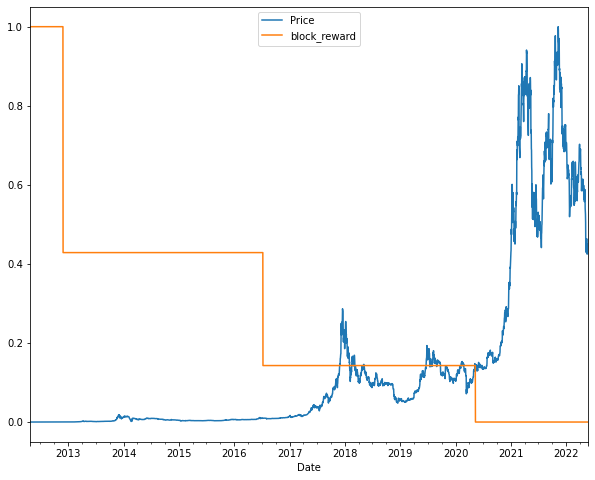

In [559]:
# Now let's plot the above
noramlized_df.plot(figsize=(10, 8));

Now we will make a windowed dataset with the help of `pandas.DataFrame.shift` as we performed earlier. 

In [560]:
btc_block_window = btc_block.copy() # keep the original dataframe intact

# Making shift operation
for i in range(sequence_length): # predicting for 7 days
    btc_block_window[f"Price+{i+1}"] = btc_block_window["Price"].shift(periods=i+1)
btc_block_window.head(8)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2012-04-25,5.1,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-26,5.1,50,5.1,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-27,5.1,50,5.1,5.1,NaN,NaN,NaN,NaN,NaN
2012-04-28,5.0,50,5.1,5.1,5.1,NaN,NaN,NaN,NaN
2012-04-29,4.9,50,5.0,5.1,5.1,5.1,NaN,NaN,NaN
2012-04-30,4.9,50,4.9,5.0,5.1,5.1,5.1,NaN,NaN
2012-05-01,5.0,50,4.9,4.9,5.0,5.1,5.1,5.1,NaN
2012-05-02,5.1,50,5.0,4.9,4.9,5.0,5.1,5.1,5.1


In [615]:
X_block = btc_block_window.dropna().drop("Price",axis=1)
y = btc_block_window.dropna()["Price"]

In [616]:
X_block.dtypes

block_reward     object
Price+1         float32
Price+2         float32
Price+3         float32
Price+4         float32
Price+5         float32
Price+6         float32
Price+7         float32
dtype: object

Since every columns except block reward is in numerical foramt, let's convert it into numerical.  

In [563]:
X_block["block_reward"] = X_block["block_reward"].astype(np.float32)

In [564]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
X_block["block_reward"] = minmax.fit_transform(tf.expand_dims(X_block["block_reward"],axis=1))

In [565]:
X_block.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2012-05-02,1.0,5.0,4.9,4.9,5.0,5.1,5.1,5.1
2012-05-03,1.0,5.1,5.0,4.9,4.9,5.0,5.1,5.1
2012-05-04,1.0,5.1,5.1,5.0,4.9,4.9,5.0,5.1
2012-05-05,1.0,5.1,5.1,5.1,5.0,4.9,4.9,5.0
2012-05-06,1.0,5.1,5.1,5.1,5.1,5.0,4.9,4.9


In [567]:
# Make train and test sets
split_size = int(len(X_block) * 0.8)
X_block_train, y_block_train = X_block[:split_size], y[:split_size]
X_block_test, y_block_test = X_block[split_size:], y[split_size:]
len(X_block_train), len(y_block_train), len(X_block_test), len(y_block_test)

(2940, 2940, 736, 736)

In [568]:
# Set the random seed
tf.random.set_seed(42)
# Make mutlimodel timeseries data 
model_8 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(1)
])

# Compile the model
model_8.compile(loss="mae", # let's choose a simple loss function 
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["mae"])

Now let's fit the model.

In [569]:
model_8.fit(X_block_train, 
            y_block_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_block_test, y_block_test),
           callbacks=[tf.keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)])

In [571]:
loss_model_8 = model_8.evaluate(X_block_test,y_block_test)
loss_model_8

23/23 [==============================] - 0s 2ms/step - loss: 1001.4738 - mae: 1001.4738


[1001.4738159179688, 1001.4738159179688]

Let's make some prediction using this data.

In [574]:
model_8.predict(X_block_test)[-5:]

array([[29402.168],
       [29231.854],
       [30276.19 ],
       [29257.725],
       [29474.48 ]], dtype=float32)

### <b> Model_9: Multivariate model (price,block_reward,volume) </b>

We have made two dataset, one of block_reward and other is of volume. Let's combine them and then make the prediction. 

In [607]:
X_block.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2012-05-02,1.0,5.0,4.9,4.9,5.0,5.1,5.1,5.1
2012-05-03,1.0,5.1,5.0,4.9,4.9,5.0,5.1,5.1
2012-05-04,1.0,5.1,5.1,5.0,4.9,4.9,5.0,5.1
2012-05-05,1.0,5.1,5.1,5.1,5.0,4.9,4.9,5.0
2012-05-06,1.0,5.1,5.1,5.1,5.1,5.0,4.9,4.9


Instead of merging data frame, let's add this column of block reward to df_vol. 

In [636]:
X_block_size = X_block["block_reward"].to_numpy()

In [637]:
X["block_reward"] = X_block_size

In [641]:
mxscale = MinMaxScaler()
X["block_reward"] = mxscale.fit_transform(np.expand_dims(X["block_reward"],axis=1))

In [642]:
X.head()

,Vol.,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7,block_reward
Date,,,,,,,,,
2012-05-02,0.000021,5.0,4.9,4.9,5.0,5.1,5.1,5.1,1.0
2012-05-03,0.000008,5.1,5.0,4.9,4.9,5.0,5.1,5.1,1.0
2012-05-04,0.000010,5.1,5.1,5.0,4.9,4.9,5.0,5.1,1.0
2012-05-05,0.000004,5.1,5.1,5.1,5.0,4.9,4.9,5.0,1.0
2012-05-06,0.000004,5.1,5.1,5.1,5.1,5.0,4.9,4.9,1.0


Checking for the length of both X and y.

In [643]:
len(X)

3676

In [644]:
len(y)

3676

Since we have merge the datframe, we will now seprate the dataframe into train and test split. 

In [645]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2940, 2940, 736, 736)

So, we have made our data into desired format. Let's fit the model.

In [646]:
# Set the random seed
tf.random.set_seed(42)
# Make mutlimodel timeseries data 
model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(1)
])

# Compile the model
model_9.compile(loss="mae", # let's choose a simple loss function 
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["mae"])

Let's plot the model with the help of `tf.keras.utils.plot_model`

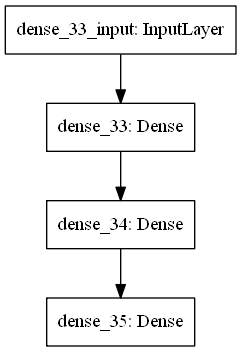

In [648]:
tf.keras.utils.plot_model(model_9)

Let's fit the model.

In [647]:
model_9.fit(X_train, 
            y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
           callbacks=[tf.keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)])

In [649]:
loss_model_9 = model_9.evaluate(X_test,y_test)
loss_model_9

23/23 [==============================] - 0s 2ms/step - loss: 996.6972 - mae: 996.6972


[996.6972045898438, 996.6972045898438]

So utilizing above two our loss has decreased.

In [650]:
model_9.predict(X_test)[-5:]

array([[29306.566],
       [29318.504],
       [30223.521],
       [29244.312],
       [29527.879]], dtype=float32)

Let's make a dataframe that comapres all the result.

In [663]:
loss = [loss_model_1[0],loss_model_3[0],loss_model_4[0],loss_model_5[0],loss_model_6[0],
        loss_model_7[0],loss_model_8[0],loss_model_9[0]]

In [664]:
loss

[170.0272979736328,
 863.2107543945312,
 1035.5074462890625,
 316.3490905761719,
 1001.1749267578125,
 1004.2461547851562,
 1001.4738159179688,
 996.6972045898438]

Now we will make a dataframe to compare the result, however we are excluding original LSTM model with huge loss, as it would distrot visualization.

In [665]:
model_name = ["model_1_window_7_out_1","model_3_LSTM_modified","model_4_GRU",
              "model_5_conv1d","model_6_win_30_out_1","model_7_multi_price&vol","model_8_multi_price&block_reward",
             "model_9_multi_price_block_reward_vol"]

In [672]:
result_df = pd.DataFrame(list(zip(model_name,loss)),columns=["Model","Loss"])
result_df.set_index("Model",inplace=True)

In [674]:
result_df

,Loss
Model,
model_1_window_7_out_1,170.027298
model_3_LSTM_modified,863.210754
model_4_GRU,1035.507446
model_5_conv1d,316.349091
model_6_win_30_out_1,1001.174927
model_7_multi_price&vol,1004.246155
model_8_multi_price&block_reward,1001.473816
model_9_multi_price_block_reward_vol,996.697205


Now let's plot the graph for better visualization in sorted order of ascending "Loss".   

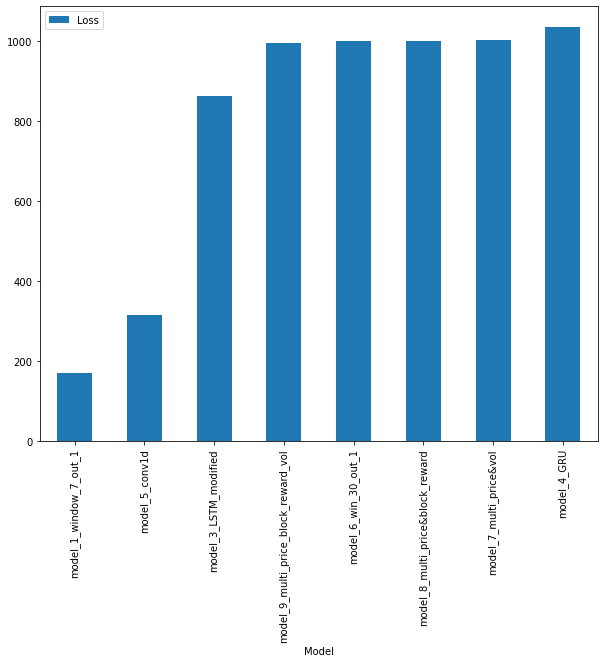

In [677]:
result_df.sort_values(by="Loss").plot(kind="bar",figsize=(10,8));

As we can see our simple dense model has outperformed the all. After this, conv1d has the better performance.